# Import packages

In [1]:
# %matplotlib notebook
from utils import *
from metrics import *
import time
import os

# algorithms
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

from pymoo.factory import get_termination
from pymoo.util.termination import collection

import plotly.express as px
from ipywidgets import *
from skimage.util import compare_images

# Reference image

In [2]:
image_path = 'input_data/01019-s1-1.png'
ground_truth_raw, ground_truth = getTargetImage(image_path,0,log=False)

ground_truth_min, ground_truth_max = ground_truth.min(), ground_truth.max()
print(ground_truth_min, ground_truth_max)

-3.7655115 0.59044015


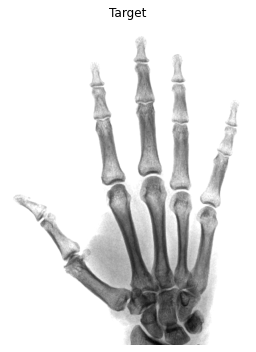

In [3]:
plt.figure(figsize= (5,5))
plt.title("Target")
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')

plt.tight_layout()


In [4]:
log_ground_truth_raw, log_ground_truth = getTargetImage(image_path,0,log=True)

# use log image
# ground_truth = log_ground_truth

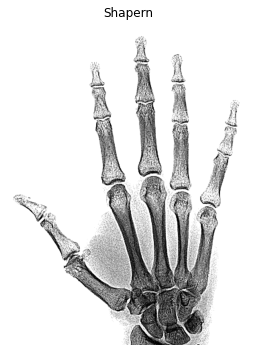

In [5]:
kernel_size = 2
scaling = 5

ground_truth_sharpen = addSharpenFilterNormalise(ground_truth, kernel_size, scaling, ground_truth_min, ground_truth_max)

plt.figure(figsize= (5,5))
plt.title("Shapern")
plt.imshow(ground_truth_sharpen, cmap='gray')
plt.axis('off')

plt.tight_layout()

# 3D hand model

In [6]:
hand_model = plt.imread('input_data/hand_model.png')

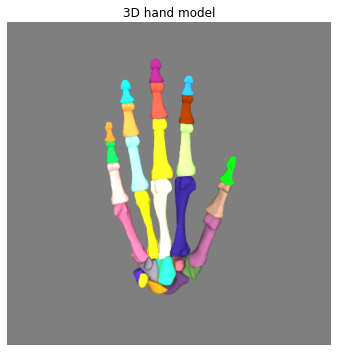

In [7]:
plt.figure(figsize= (10,5))
plt.title("3D hand model")
plt.imshow(hand_model)
plt.axis('off')

plt.tight_layout()

# Set X-ray simulation parameters

In [8]:
model_path = 'input_data/hand.dae'

setXRayEnvironment(model_path,0) 

In [9]:
x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = (x_ray_image-x_ray_image.mean())/x_ray_image.std()

x_ray_image_min, x_ray_image_max = x_ray_image.min(), x_ray_image.max()
print(x_ray_image_min, x_ray_image_max)

-6.538776048194764 0.4952867752409985


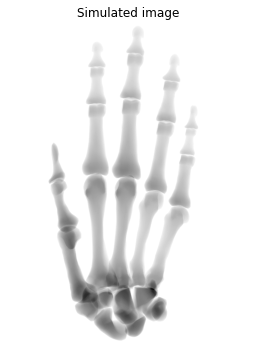

In [10]:
plt.figure(figsize= (10,5))
plt.title("Simulated image")
plt.imshow(x_ray_image, cmap='gray')
plt.axis('off')

plt.tight_layout()

In [11]:
x_ray_image_sharpen = addSharpenFilterNormalise(x_ray_image, kernel_size, scaling, x_ray_image_min, x_ray_image_max)

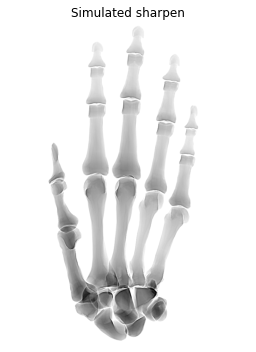

In [12]:
plt.figure(figsize= (10,5))
plt.title("Simulated sharpen")
plt.imshow(x_ray_image_sharpen, cmap='gray')
plt.axis('off')

plt.tight_layout()

# Matching fingers visualisation

In [18]:
def update_figure(sod_ratio, root_x, root_y, root_z, thumb, index, middle, ring, little):
    
    params = [sod_ratio, 100., root_x, root_y, root_z,
             thumb, 0., 0.,
             index, 0., 0., 0.,
             middle, 0., 0., 0.,
             ring, 0., 0., 0.,
             little, 0., 0., 0.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]
    
    x_ray_image = computePredictedImage(np.array(params))
    x_ray_image_sharpen = addSharpenFilterNormalise(x_ray_image, kernel_size, scaling, x_ray_image.min(), x_ray_image.max())
    
    comp_checkerboard = compare_images(ground_truth_sharpen, x_ray_image_sharpen, method='checkerboard')
    comp_diff = compare_images(ground_truth_sharpen, x_ray_image_sharpen, method='diff')
    
    plt.figure(figsize= (20,10))

    plt.subplot(141)
    plt.imshow(ground_truth_sharpen, cmap="gray")
    plt.colorbar(orientation='horizontal')
    plt.title("Target")

    plt.subplot(142)
    plt.imshow(x_ray_image_sharpen, cmap="gray")
    plt.colorbar(orientation='horizontal')
    plt.title("Simulated")

    plt.subplot(143)
    plt.imshow(comp_checkerboard, cmap="gray")
    plt.colorbar(orientation='horizontal')
    plt.title("Checkerboard")
    
    plt.subplot(144)
    plt.imshow(comp_diff, cmap="gray")
    plt.colorbar(orientation='horizontal')
    plt.title("Diff")

    plt.tight_layout()
    plt.savefig('plots/hand-tune.pdf')
    plt.savefig('plots/hand-tune.png')


interact_manual(update_figure, 
                sod_ratio=widgets.FloatSlider(min=0.75, max=0.99, step=0.01, value=0.95), 
                root_x=widgets.IntSlider(min=-90, max=90, step=1, value=-17), 
                root_y=widgets.IntSlider(min=-90, max=90, step=1, value=6), 
                root_z=widgets.IntSlider(min=-90, max=90, step=1, value=32), 
                thumb=widgets.IntSlider(min=-90, max=90, step=1, value=-18), 
                index=widgets.IntSlider(min=-90, max=90, step=1, value=14), 
                middle=widgets.IntSlider(min=-90, max=90, step=1, value=20), 
                ring=widgets.IntSlider(min=-90, max=90, step=1, value=17), 
                little=widgets.IntSlider(min=-90, max=90, step=1, value=37));


interactive(children=(FloatSlider(value=0.95, description='sod_ratio', max=0.99, min=0.75, step=0.01), IntSlid…

In [19]:
plt.close()

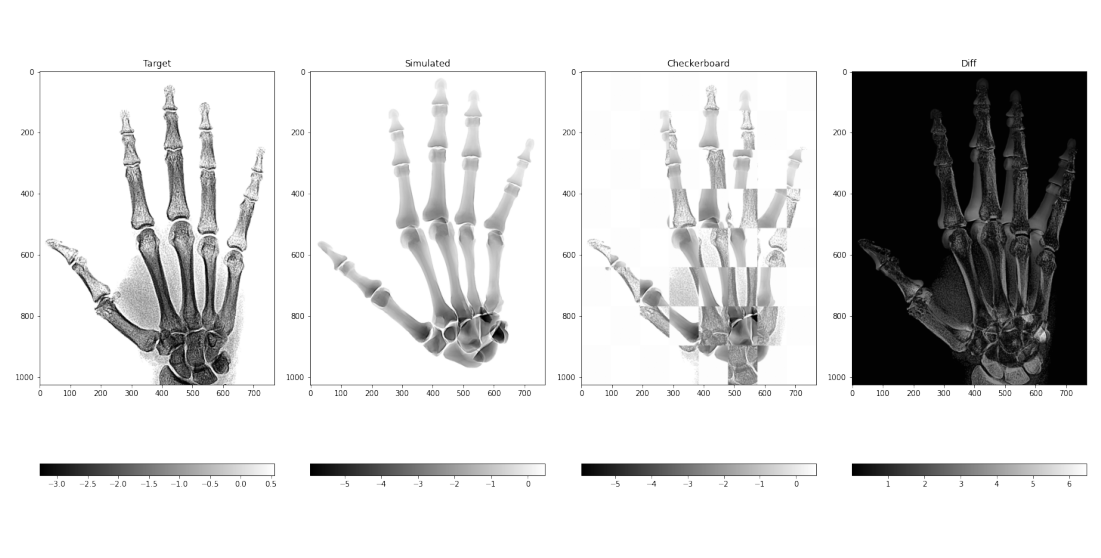

In [20]:
plt.figure(figsize= (20,10))
fig_hand_tune = plt.imread('plots/hand-tune.png')
plt.imshow(fig_hand_tune)
plt.axis('off')
plt.show()

# CMA-ES

# NSGA-II

In [13]:
# define boundaries
xl = np.array([0.7, 10., -2., -2., -2.,
            -10., -20., -10.,
            -10., -20., -20., -20.,
            -10., -20., -20., -20.,
            -10., -20., -20. ,-20.,
            -10., -20., -20., -20.,
            0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

xu = np.array([0.95, 1000., 2., 2., 2.,
            10., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

# ground truth to be used
ground_truth = ground_truth_sharpen

In [14]:
def objectiveFunction(aPrediction):

    obj_list = []

    for i in aPrediction:

        pred_image = computePredictedImage(i)
        pred_image = addSharpenFilterNormalise(pred_image, kernel_size, scaling, pred_image.min(), pred_image.max())

        row = []

        dzncc = (1.0 - ZNCC(ground_truth, pred_image)) / 2.0
        row.append(dzncc)
        
        dssim = (1.0 - SSIM(ground_truth, pred_image)) / 2.0
        row.append(dssim)

        mae = MAE(ground_truth, pred_image)
        row.append(mae)

        rmse = RMSE(ground_truth, pred_image)
        row.append(rmse)

        dmi = (2.0 - MI(ground_truth, pred_image)) / 2.0
        row.append(dmi)
        
        obj_list.append(row)


    return obj_list

In [15]:
class multiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=38, 
                         n_obj=5, 
                         n_constr=0, 
                         xl=xl,
                         xu=xu)


    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.array(objectiveFunction(x))
        

In [16]:
problem = multiObjectiveProblem()

pop_size = 100

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "00:20:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)

if False: #os.path.exists("output_data/nsga2-X-sharpen.dat") and os.path.exists("output_data/nsga2-F-sharpen.dat"):

    res_nsga2_X = np.loadtxt("output_data/nsga2-X-sharpen.dat")
    res_nsga2_F = np.loadtxt("output_data/nsga2-F-sharpen.dat")

else:

    algorithm = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True)

    res_nsga2 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga2_X = res_nsga2.X
    res_nsga2_F = res_nsga2.F

    np.savetxt("output_data/nsga2-X-sharpen.dat", res_nsga2_X)
    np.savetxt("output_data/nsga2-F-sharpen.dat", res_nsga2_F)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       5 |            - |            -
    2 |     200 |       3 |  1.000000000 |        ideal
    3 |     300 |       5 |  0.686783120 |        ideal


/home/ti/.local/lib/python3.8/site-packages/pymoo/util/normalization.py:73: RuntimeWarning: invalid value encountered in greater_equal
  assert np.all(np.logical_or(xu >= xl, any_nan)), "xl must be less or equal than xu."


    4 |     400 |       1 |  0.013409183 |        ideal
    5 |     500 |       3 |  0.989509469 |        ideal
    6 |     600 |       5 |  0.380264573 |        ideal
    7 |     700 |       6 |  0.665942606 |        ideal
    8 |     800 |       5 |  0.894297217 |        ideal
    9 |     900 |       3 |  0.631463158 |        ideal
   10 |    1000 |       4 |  0.704364359 |        ideal
   11 |    1100 |       6 |  0.359789119 |        ideal
   12 |    1200 |       4 |  0.898299151 |        ideal
   13 |    1300 |       3 |  0.751163140 |        ideal
   14 |    1400 |       4 |  0.410164810 |        ideal
   15 |    1500 |       5 |  0.377401760 |        ideal
   16 |    1600 |       6 |  0.832185328 |        ideal
   17 |    1700 |       5 |  1.032155351 |        ideal
   18 |    1800 |       6 |  0.202624611 |        ideal
   19 |    1900 |      10 |  0.193260472 |        ideal
   20 |    2000 |      15 |  0.172390684 |        ideal
   21 |    2100 |      11 |  0.266093722 |      

In [17]:
best_dzncc_id = np.argmin(res_nsga2_F[:,0])
best_dssim_id = np.argmin(res_nsga2_F[:,1])
best_mae_id = np.argmin(res_nsga2_F[:,2])
best_rmse_id = np.argmin(res_nsga2_F[:,3])
best_dmi_id = np.argmin(res_nsga2_F[:,4])

print("Lowest DZNCC:", res_nsga2_F[:,0].min(), best_dzncc_id, res_nsga2_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga2_F[:,1].min(), best_dssim_id, res_nsga2_X[best_dssim_id])
print("Lowest MAE:",   res_nsga2_F[:,2].min(), best_mae_id,   res_nsga2_X[best_mae_id])
print("Lowest RMSE:",  res_nsga2_F[:,3].min(), best_rmse_id,  res_nsga2_X[best_rmse_id])
print("Lowest DMI:",  res_nsga2_F[:,4].min(), best_dmi_id,  res_nsga2_X[best_dmi_id])

Lowest DZNCC: 0.32230153661095606 24 [ 9.49870767e-01  3.54330765e+02 -1.99957290e+00  1.98140510e+00
  1.99446643e+00 -9.94380840e+00 -1.99397945e+01 -9.84727050e+00
  7.37428437e+00 -1.80044676e+01 -1.89964494e+01 -1.80146734e+01
  8.92997586e+00 -1.57525830e+01 -1.67257835e+01 -1.63407087e+01
 -9.96175871e+00 -1.24757804e+01 -2.24603335e+00 -2.38961960e+00
 -5.42682405e+00 -3.48075245e+00 -8.69119043e-02 -7.84022259e+00
  9.01108053e-01  9.11464213e-01  9.52327513e-01  9.19027747e-01
  9.83709521e-01  9.01125176e-01  9.84214586e-01  1.02936227e+00
  1.09587809e+00  1.08350333e+00  9.99222844e-01  1.09287577e+00
  1.06728543e+00  9.70417784e-01]
Lowest DSSIM: 0.2152984956710517 14 [ 9.49890814e-01  2.96342601e+02 -1.99986021e+00  1.75995588e+00
  1.98813468e+00 -9.54835455e+00 -1.98110478e+01 -9.36571455e+00
  6.76097445e+00 -1.89346556e+01 -1.89684722e+01 -1.81317379e+01
  9.62266277e+00 -1.80385716e+01 -1.67043039e+01 -1.83983391e+01
 -9.98416218e+00 -1.23070052e+01 -2.25341432e+00

In [18]:
xray_image_dzncc_nsga2 = computePredictedImage(res_nsga2_X[best_dzncc_id])
xray_image_dssim_nsga2   = computePredictedImage(res_nsga2_X[best_dssim_id])
xray_image_mae_nsga2  = computePredictedImage(res_nsga2_X[best_mae_id])
xray_image_rmse_nsga2 = computePredictedImage(res_nsga2_X[best_rmse_id])
xray_image_dmi_nsga2  = computePredictedImage(res_nsga2_X[best_dmi_id])

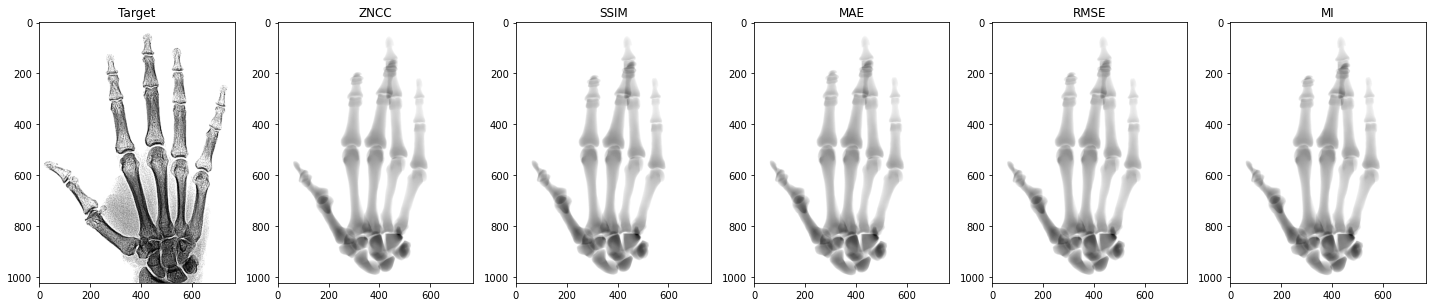

In [19]:
plt.figure(figsize= (20,10))

# plt.suptitle("Results")

plt.subplot(161)
plt.imshow(ground_truth, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(162)
plt.imshow(xray_image_dzncc_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("ZNCC")

plt.subplot(163)
plt.imshow(xray_image_dssim_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("SSIM")

plt.subplot(164)
plt.imshow(xray_image_mae_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MAE")

plt.subplot(165)
plt.imshow(xray_image_rmse_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("RMSE")

plt.subplot(166)
plt.imshow(xray_image_dmi_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MI")

plt.tight_layout()

plt.savefig('plots/nsga2-sharpen.pdf')
plt.savefig('plots/nsga2-sharpen.png')

In [20]:
df_nsga2 = pd.DataFrame(data=np.append(res_nsga2_X, res_nsga2_F, axis=1),
                  columns=["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9",
                           "x10", "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19",
                           "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29",
                           "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37",
                           "DZNCC", "DSSIM", "MAE", "RMSE", "DMI"])

df_nsga2.to_csv("output_data/optimiser-nsga2-sharpen.csv")

In [21]:
fig = px.parallel_coordinates(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "DMI"]], color="DZNCC")
fig.show()

fig.write_image("plots/NSGA2-parallel_coordinates-sharpen.pdf", engine="kaleido")
fig.write_image("plots/NSGA2-parallel_coordinates-sharpen.png", engine="kaleido")

In [22]:
fig = px.scatter_matrix(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "DMI"]])

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image("plots/NSGA2-scatter_matrix-sharpen.pdf", engine="kaleido")
fig.write_image("plots/NSGA2-scatter_matrix-sharpen.png", engine="kaleido")